In [1]:
import pandas as pd
import numpy as np
import glob
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_sample_weight
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_fscore_support





Data is present in Epl/data/ and seperate features required are taken to reduce the difficulties in cleaning..empty coloumns if any are filled with NaN.

In [59]:
try:
        data = pd.read_csv("full_feature_dataset1.csv", encoding='utf-8')
except UnicodeDecodeError:
        data = pd.read_csv("full_feature_dataset1.csv", encoding='ISO-8859-1')
print(f"Dataset loaded. Initial shape: {data.shape}")
data = data.drop(columns=['Date'])


Dataset loaded. Initial shape: (9232, 38)


Now that data is ready we have to clean it by checking for duplicates and null values.

In [60]:
print(data.isnull().sum())
print((data.isnull().mean()*100).round(2))

FTR              0
HomeTeam         0
AwayTeam         0
Avg_Odds_H       0
Avg_Odds_D       0
Avg_Odds_A       0
H_form_FTHG      0
H_form_FTAG      0
H_form_HS        0
H_form_AS        0
H_form_HF        0
H_form_AF        0
H_form_HC        0
H_form_AC        0
H_form_HST       0
H_form_AST       0
H_form_HY        0
H_form_AY        0
H_form_HR        0
H_form_AR        0
A_form_FTHG      0
A_form_FTAG      0
A_form_HS        0
A_form_AS        0
A_form_HF        0
A_form_AF        0
A_form_HC        0
A_form_AC        0
A_form_HST       0
A_form_AST       0
A_form_HY        0
A_form_AY        0
A_form_HR        0
A_form_AR        0
H_H2H_win_pct    0
A_H2H_win_pct    0
H2H_draw_pct     0
dtype: int64
FTR              0.0
HomeTeam         0.0
AwayTeam         0.0
Avg_Odds_H       0.0
Avg_Odds_D       0.0
Avg_Odds_A       0.0
H_form_FTHG      0.0
H_form_FTAG      0.0
H_form_HS        0.0
H_form_AS        0.0
H_form_HF        0.0
H_form_AF        0.0
H_form_HC        0.0
H_form_AC  

This shows that the dataset has only a very few negligable output there is 1 missing value and that missing value exists in all features so we could drop that row.

In [61]:
data = data.dropna()
print("After dropping missing:",data.shape)
print("Remaining NaN:",data.isnull().sum().sum())

After dropping missing: (9232, 37)
Remaining NaN: 0


In [62]:
duplicates = data.duplicated().sum()
print("Number of duplicated rows:",duplicates)
data=data.drop(columns=['H_form_FTAG','H_form_FTHG','A_form_FTHG','A_form_FTAG'])

Number of duplicated rows: 0


In [63]:
print(data.columns)
le = LabelEncoder()
data['FTR']=le.fit_transform(data['FTR'])

Index(['FTR', 'HomeTeam', 'AwayTeam', 'Avg_Odds_H', 'Avg_Odds_D', 'Avg_Odds_A',
       'H_form_HS', 'H_form_AS', 'H_form_HF', 'H_form_AF', 'H_form_HC',
       'H_form_AC', 'H_form_HST', 'H_form_AST', 'H_form_HY', 'H_form_AY',
       'H_form_HR', 'H_form_AR', 'A_form_HS', 'A_form_AS', 'A_form_HF',
       'A_form_AF', 'A_form_HC', 'A_form_AC', 'A_form_HST', 'A_form_AST',
       'A_form_HY', 'A_form_AY', 'A_form_HR', 'A_form_AR', 'H_H2H_win_pct',
       'A_H2H_win_pct', 'H2H_draw_pct'],
      dtype='object')


I have done label encoding for all categorical coloumns and the encoder function is also saved in encoders[] to decode for further use

In [64]:
#splitting data into label and feature input

y = data['FTR']

X = data.drop('FTR', axis=1)


In [65]:
print(data.head())

   FTR     HomeTeam    AwayTeam  Avg_Odds_H  Avg_Odds_D  Avg_Odds_A  \
0    2   Sunderland       Derby       1.760       3.325       3.875   
1    0      Everton  Man United       4.315       3.250       1.700   
2    2  Southampton   Newcastle       2.750       3.225       2.225   
3    2      Arsenal    Coventry       1.250       4.415      10.250   
4    2     Charlton   Tottenham       2.685       3.225       2.275   

   H_form_HS  H_form_AS  H_form_HF  H_form_AF  ...  A_form_AC  A_form_HST  \
0       13.8       10.6       16.2       15.0  ...        6.4         5.6   
1       12.4       10.0       15.2       11.8  ...        3.4         8.8   
2       11.4        9.8       11.2       12.8  ...        4.6         5.2   
3       12.8       11.8       16.0       18.2  ...        5.6         3.2   
4       13.6        8.8       14.6       14.0  ...        3.8         6.4   

   A_form_AST  A_form_HY  A_form_AY  A_form_HR  A_form_AR  H_H2H_win_pct  \
0         5.0        1.8        2.

In [66]:
print(X.head)


<bound method NDFrame.head of          HomeTeam        AwayTeam  Avg_Odds_H  Avg_Odds_D  Avg_Odds_A  \
0      Sunderland           Derby       1.760       3.325       3.875   
1         Everton      Man United       4.315       3.250       1.700   
2     Southampton       Newcastle       2.750       3.225       2.225   
3         Arsenal        Coventry       1.250       4.415      10.250   
4        Charlton       Tottenham       2.685       3.225       2.275   
...           ...             ...         ...         ...         ...   
9227      Ipswich        West Ham       3.000       3.800       2.200   
9228       Fulham        Man City       5.000       4.200       1.600   
9229  Bournemouth       Leicester       1.330       5.250       8.500   
9230    Liverpool  Crystal Palace       1.400       6.000       5.750   
9231       Wolves       Brentford       2.700       3.700       2.450   

      H_form_HS  H_form_AS  H_form_HF  H_form_AF  H_form_HC  ...  A_form_AC  \
0          13.

Splitting Data

In [67]:
from sklearn.model_selection import train_test_split
# Stratified split to preserve class ratios
X_train_cat_split, X_test_cat_split, y_train_cat_split, y_test_cat_split = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


CATBOOST CLASSIFIER

Fitting with catboost 

In [68]:
# Define which columns are categorical
from catboost import CatBoostClassifier
cat_features = ['HomeTeam', 'AwayTeam']

# Build model
model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=7,
    loss_function='MultiClass',
    auto_class_weights='Balanced',
    early_stopping_rounds=50,
    verbose=100
)

# Train model
model.fit(X_train_cat_split, y_train_cat_split, cat_features=cat_features, eval_set=(X_test_cat_split, y_test_cat_split))


0:	learn: 1.0907874	test: 1.0914378	best: 1.0914378 (0)	total: 47.2ms	remaining: 47.1s
100:	learn: 0.9491462	test: 1.0108332	best: 1.0101786 (76)	total: 4.49s	remaining: 40s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.010178635
bestIteration = 76

Shrink model to first 77 iterations.


Predicting and accuracy

In [69]:
y_pred = model.predict(X_test_cat_split)

# Accuracy
print("Accuracy:", accuracy_score(y_test_cat_split, y_pred))

# Full classification report
print(classification_report(y_test_cat_split, y_pred))


Accuracy: 0.48673524634542503
              precision    recall  f1-score   support

           0       0.53      0.51      0.52       549
           1       0.27      0.39      0.32       453
           2       0.66      0.53      0.59       845

    accuracy                           0.49      1847
   macro avg       0.49      0.47      0.47      1847
weighted avg       0.53      0.49      0.50      1847



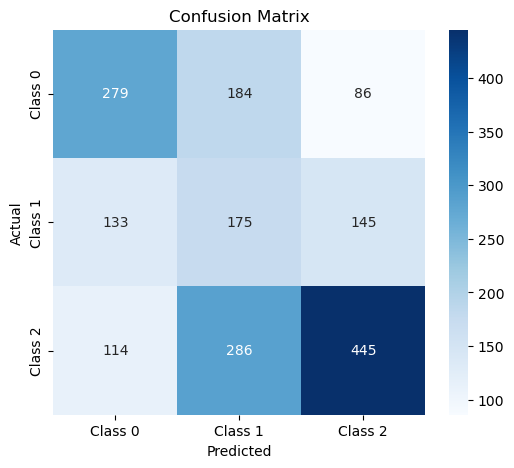

In [70]:
cm = confusion_matrix(y_test_cat_split, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0','Class 1','Class 2'], 
            yticklabels=['Class 0','Class 1','Class 2'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


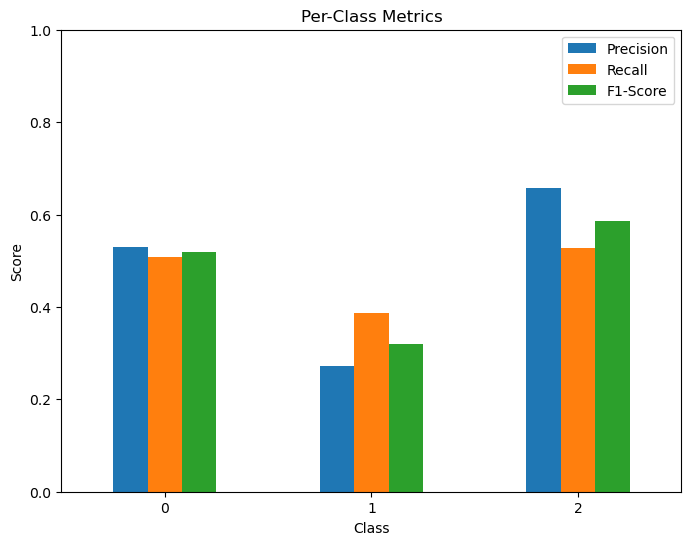

In [71]:
prec, rec, f1, _ = precision_recall_fscore_support(y_test_cat_split, y_pred, average=None)

metrics_df = {
    "Class": ['0','1','2'],
    "Precision": prec,
    "Recall": rec,
    "F1-Score": f1
}

metrics_df = pd.DataFrame(metrics_df)

metrics_df.plot(x="Class", kind="bar", figsize=(8,6))
plt.title("Per-Class Metrics")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.ylim(0,1)
plt.show()

In [74]:

categorical_col = data.select_dtypes(include ='object').columns
encoders = {}
for c in categorical_col:
    le = LabelEncoder()
    data[c]=le.fit_transform(data[c])
    encoders[c]=le
print(data.head())

   FTR  HomeTeam  AwayTeam  Avg_Odds_H  Avg_Odds_D  Avg_Odds_A  H_form_HS  \
0    2        38        16       1.760       3.325       3.875       13.8   
1    0        17        27       4.315       3.250       1.700       12.4   
2    2        36        29       2.750       3.225       2.225       11.4   
3    2         0        14       1.250       4.415      10.250       12.8   
4    2        12        40       2.685       3.225       2.275       13.6   

   H_form_AS  H_form_HF  H_form_AF  ...  A_form_AC  A_form_HST  A_form_AST  \
0       10.6       16.2       15.0  ...        6.4         5.6         5.0   
1       10.0       15.2       11.8  ...        3.4         8.8         4.4   
2        9.8       11.2       12.8  ...        4.6         5.2         4.4   
3       11.8       16.0       18.2  ...        5.6         3.2         6.6   
4        8.8       14.6       14.0  ...        3.8         6.4         4.4   

   A_form_HY  A_form_AY  A_form_HR  A_form_AR  H_H2H_win_pct  A_H2H_

Splitting data for xgboost

In [75]:
y = data['FTR']
x = data.drop('FTR',axis=1)

In [76]:
from sklearn.model_selection import train_test_split
# Stratified split to preserve class ratios
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(
    x, y, test_size=0.2, random_state=42, stratify=y
)

In [77]:
from imblearn.over_sampling import SMOTE
from collections import Counter



from collections import Counter

# Count samples in training set
counts = Counter(y_train_split)
total = sum(counts.values())

class_weight = {cls: total / (len(counts) * count) for cls, count in counts.items()}
print(class_weight)



counts = Counter(y_train_split)
print("Before SMOTE:", counts)
undetermined_label = 1  
multiplier = 2
target_samples = counts[undetermined_label] * multiplier
sm = SMOTE(sampling_strategy={undetermined_label: target_samples}, random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_split, y_train_split)

print("After SMOTE:", Counter(y_train_res))
X_train_res = X_train_res.astype(np.float32)
y_train_res = y_train_res.astype(np.int64)
print(X_train_res.shape)
print(y_train_res.shape)




print("Class distribution after SMOTE:", dict(zip(*np.unique(y_train_res, return_counts=True))))

{0: 1.1230231143552312, 2: 0.7283037475345168, 1: 1.3577863577863578}
Before SMOTE: Counter({2: 3380, 0: 2192, 1: 1813})
After SMOTE: Counter({1: 3626, 2: 3380, 0: 2192})
(9198, 32)
(9198,)
Class distribution after SMOTE: {np.int64(0): np.int64(2192), np.int64(1): np.int64(3626), np.int64(2): np.int64(3380)}


In [78]:

weights = compute_sample_weight(class_weight='balanced', y=y_train_split)
model = XGBClassifier(
    n_estimators=500,
    max_depth=5,
    learning_rate=0.05,
    objective='multi:softprob',  
    num_class=3,
    eval_metric='mlogloss',
    random_state = 42
)
param_grid = {
    'n_estimators':[800,1000],
    'max_depth': [4, 5, 6],
    'learning_rate':[0.05,0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='f1_macro',  
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train_split, y_train_split,sample_weight=weights)
best_model = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 800, 'subsample': 0.8}


In [79]:

from sklearn.metrics import f1_score

# Get predicted probabilities
y_proba = best_model.predict_proba(X_test_split)

# Custom thresholds per class
thresholds = [0.4, 0.6, 0.4]  # start with 0.5 for all classes

def predict_with_thresholds(probs, thresholds):
    preds = []
    for p in probs:
     #Assign class if probability > threshold, else take max
        assigned = [i for i, prob in enumerate(p) if prob >= thresholds[i]]
        if assigned:
            preds.append(assigned[0])
        else:
            preds.append(np.argmax(p))
    return np.array(preds)

y_pred = predict_with_thresholds(y_proba, thresholds)

print("F1 score macro:", f1_score(y_test_split, y_pred, average='macro'))



F1 score macro: 0.4490322967577933


In [80]:

# Accuracy
print("Accuracy:", accuracy_score(y_test_split, y_pred))

# Full classification report
print(classification_report(y_test_split, y_pred))


Accuracy: 0.48619382782891174
              precision    recall  f1-score   support

           0       0.46      0.53      0.49       549
           1       0.27      0.24      0.25       453
           2       0.61      0.59      0.60       845

    accuracy                           0.49      1847
   macro avg       0.45      0.45      0.45      1847
weighted avg       0.48      0.49      0.48      1847



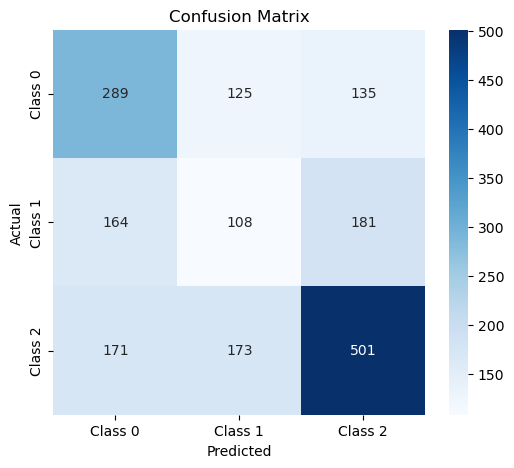

In [81]:
cm = confusion_matrix(y_test_split, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0','Class 1','Class 2'], 
            yticklabels=['Class 0','Class 1','Class 2'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


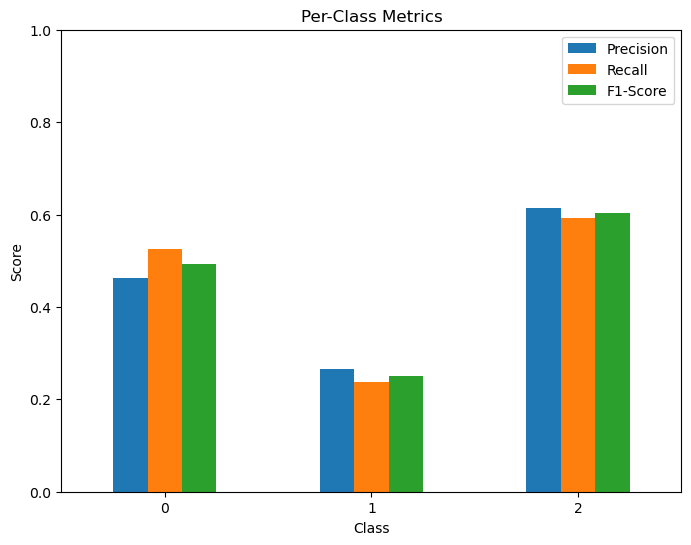

In [82]:
prec, rec, f1, _ = precision_recall_fscore_support(y_test_split, y_pred, average=None)

metrics_df = {
    "Class": ['0','1','2'],
    "Precision": prec,
    "Recall": rec,
    "F1-Score": f1
}

metrics_df = pd.DataFrame(metrics_df)

metrics_df.plot(x="Class", kind="bar", figsize=(8,6))
plt.title("Per-Class Metrics")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.ylim(0,1)
plt.show()

BALANCED RANDOM FOREST CLASSIFIER

In [99]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

# Define parameter grid
param_dist = {
    "n_estimators": [800,1000,1200],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4,5,10],
    "max_features": ['sqrt','log2']
}

# Initialize model
rf = BalancedRandomForestClassifier(random_state=42)

# Randomized search
random_search = RandomizedSearchCV(
    rf, param_distributions=param_dist,
    n_iter=20,  
    cv=3,       
    scoring="f1_macro",  
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train_split, y_train_split)

print("Best Parameters:", random_search.best_params_)
print("Best Score (CV F1):", random_search.best_score_)


Best Parameters: {'n_estimators': 1000, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 10}
Best Score (CV F1): 0.6081930932816711


In [100]:
best_rf = random_search.best_estimator_

y_proba = best_rf.predict_proba(X_test_split)
y_pred = np.argmax(y_proba, axis=1) 


In [101]:
# Accuracy
print("Accuracy:", accuracy_score(y_test_split, y_pred))

# Full classification report
print(classification_report(y_test_split, y_pred))

Accuracy: 0.6238044633368757
              precision    recall  f1-score   support

           0       0.66      0.68      0.67       556
           1       0.38      0.47      0.42       464
           2       0.79      0.67      0.72       862

    accuracy                           0.62      1882
   macro avg       0.61      0.61      0.60      1882
weighted avg       0.65      0.62      0.63      1882



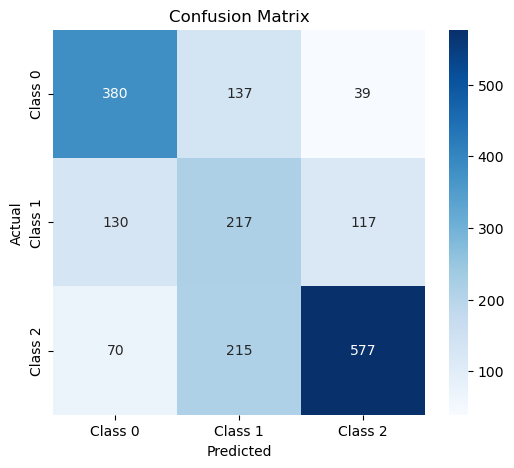

In [102]:
cm = confusion_matrix(y_test_split, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0','Class 1','Class 2'], 
            yticklabels=['Class 0','Class 1','Class 2'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


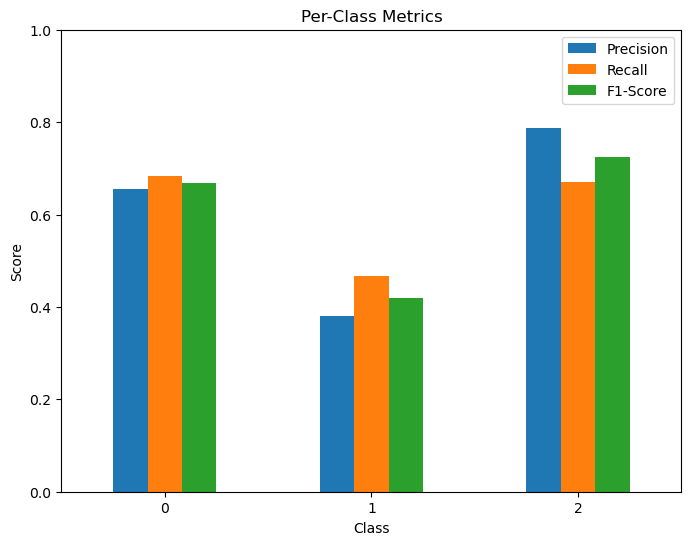

In [103]:
prec, rec, f1, _ = precision_recall_fscore_support(y_test_split, y_pred, average=None)

metrics_df = {
    "Class": ['0','1','2'],
    "Precision": prec,
    "Recall": rec,
    "F1-Score": f1
}

metrics_df = pd.DataFrame(metrics_df)

metrics_df.plot(x="Class", kind="bar", figsize=(8,6))
plt.title("Per-Class Metrics")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.ylim(0,1)
plt.show()

RANDOM FOREST CLASSIFIER

In [83]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

# Define parameter grid
param_dist = {
    "n_estimators": [800,1000,1200],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4,5,10],
    "max_features": ['sqrt','log2'],
    "bootstrap": [True, False]
}

# Initialize model
rf = RandomForestClassifier(random_state=42)

# Randomized search
random_search = RandomizedSearchCV(
    rf, param_distributions=param_dist,
    n_iter=20,  # number of random combinations
    cv=3,       # 3-fold cross validation
    scoring="f1_macro",  # you can also try "accuracy"
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train_res, y_train_res)

print("Best Parameters:", random_search.best_params_)
print("Best Score (CV F1):", random_search.best_score_)

Best Parameters: {'n_estimators': 800, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': None, 'bootstrap': True}
Best Score (CV F1): 0.6865774115877455


In [89]:
best_rf = random_search.best_estimator_

y_proba = best_rf.predict_proba(X_test_split)
y_pred = np.argmax(y_proba, axis=1) 


In [90]:
# Accuracy
print("Accuracy:", accuracy_score(y_test_split, y_pred))

# Full classification report
print(classification_report(y_test_split, y_pred))

Accuracy: 0.6238044633368757
              precision    recall  f1-score   support

           0       0.66      0.68      0.67       556
           1       0.38      0.47      0.42       464
           2       0.79      0.67      0.72       862

    accuracy                           0.62      1882
   macro avg       0.61      0.61      0.60      1882
weighted avg       0.65      0.62      0.63      1882



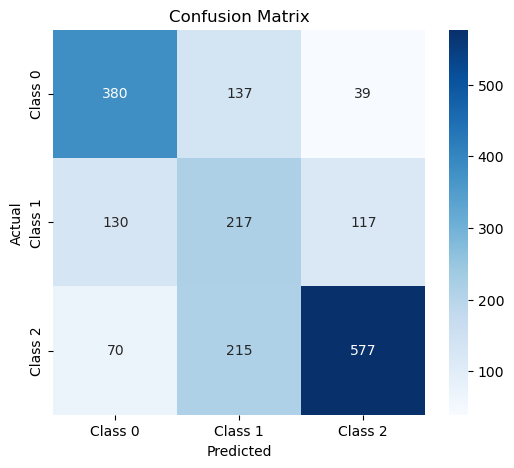

In [91]:
cm = confusion_matrix(y_test_split, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0','Class 1','Class 2'], 
            yticklabels=['Class 0','Class 1','Class 2'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


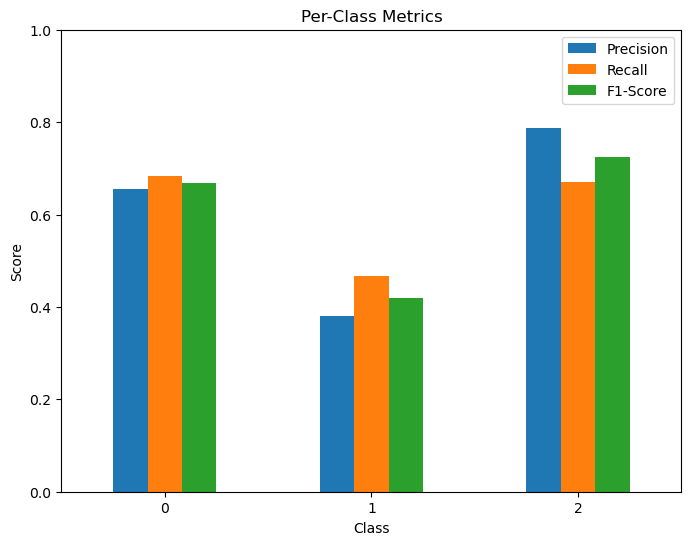

In [93]:
prec, rec, f1, _ = precision_recall_fscore_support(y_test_split, y_pred, average=None)

metrics_df = {
    "Class": ['0','1','2'],
    "Precision": prec,
    "Recall": rec,
    "F1-Score": f1
}

metrics_df = pd.DataFrame(metrics_df)

metrics_df.plot(x="Class", kind="bar", figsize=(8,6))
plt.title("Per-Class Metrics")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.ylim(0,1)
plt.show()

In [83]:
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
import numpy as np

# Base classifier options
base_estimators = [
    DecisionTreeClassifier(max_depth=1),
    DecisionTreeClassifier(max_depth=2),
    DecisionTreeClassifier(max_depth=3)
]

# Parameter grid
param_dist = {
    "n_estimators": [10, 20, 30],
    "estimator": base_estimators
}

# Initialize EasyEnsemble
eec = EasyEnsembleClassifier(random_state=42, n_jobs=-1)

# Randomized search
rs = RandomizedSearchCV(
    estimator=eec,
    param_distributions=param_dist,
    n_iter=10,        # number of random combinations
    cv=3,             # 3-fold cross-validation
    scoring="f1_macro",  # optimize macro F1 (balances all classes)
    n_jobs=-1,
    random_state=42
)

# Fit on original imbalanced data (EEC handles balancing internally)
rs.fit(X_train_split, y_train_split)

# Best parameters
print("Best Parameters:", rs.best_params_)
print("Best CV F1 (macro):", rs.best_score_)

# Evaluate on test set
y_pred = rs.predict(X_test_split)
print(classification_report(y_test_split, y_pred))


c:\Users\arnas\miniconda3\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Parameters: {'n_estimators': 20, 'estimator': DecisionTreeClassifier(max_depth=3)}
Best CV F1 (macro): 0.49290552705185003
              precision    recall  f1-score   support

           0       0.58      0.43      0.49       549
           1       0.28      0.43      0.34       453
           2       0.65      0.57      0.61       845

    accuracy                           0.49      1847
   macro avg       0.50      0.48      0.48      1847
weighted avg       0.54      0.49      0.51      1847



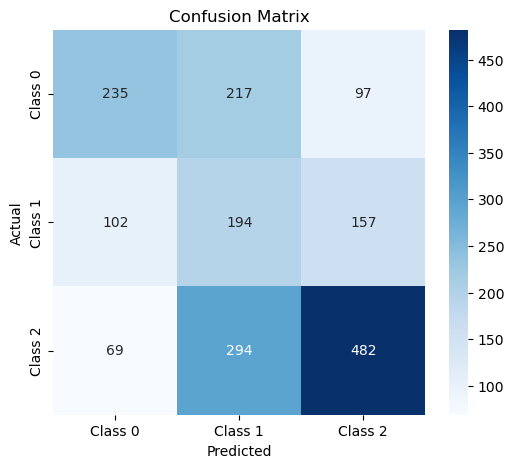

In [84]:
cm = confusion_matrix(y_test_split, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0','Class 1','Class 2'], 
            yticklabels=['Class 0','Class 1','Class 2'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


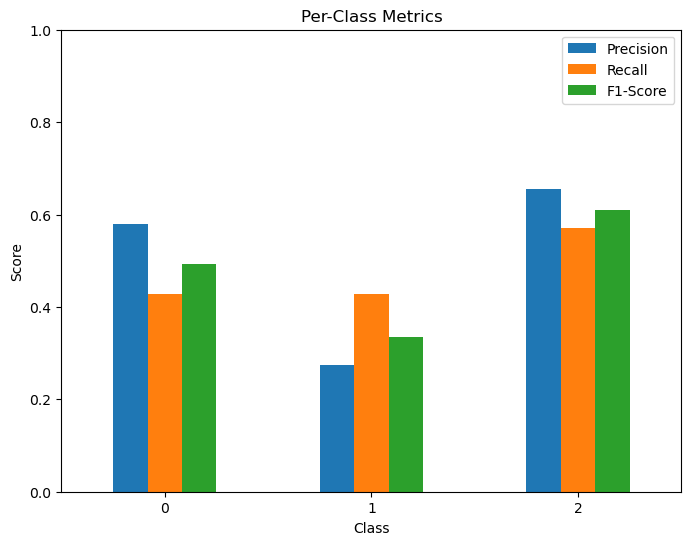

In [85]:
prec, rec, f1, _ = precision_recall_fscore_support(y_test_split, y_pred, average=None)

metrics_df = {
    "Class": ['0','1','2'],
    "Precision": prec,
    "Recall": rec,
    "F1-Score": f1
}

metrics_df = pd.DataFrame(metrics_df)

metrics_df.plot(x="Class", kind="bar", figsize=(8,6))
plt.title("Per-Class Metrics")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.ylim(0,1)
plt.show()